In [ ]:
! pip install tensorflow



# Proyecto de análisis de frutas podridas y en buen estado
En los supermercados de Popayán, uno de los principales desafíos en el área de frutas y verduras es la detección temprana de productos en mal estado, ya que esto afecta directamente la calidad ofrecida al cliente, genera pérdidas económicas y puede impactar negativamente en la salud de los consumidores.
Tradicionalmente, la identificación de frutas podridas se realiza de manera manual, lo que conlleva errores humanos, falta de estandarización y un proceso ineficiente.

Para ello, se realizarán los siguientes pasos:
1. Buscar, descargar analizar dataset relacionado a frutas sanas y descompuestas 
2. importacion de librerias 
3. Normalizar datos 
4. Cargar las imágenes de entrenamiento y test
5. Aplicar MobileNetV2 con fine tuning.
6. Entrenar y evaluar tu modelo con precisión.

## 1. Buscar, descargar y analizar dataset relacionado con frutas sanas y descompuestas 

El dataset que se decidió utilizar para este caso es, "**Fruits fresh and rotten for classification**"

**Enlace:**= https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

El objetivo es permitir que modelos de aprendizaje automático identifiquen el estado de madurez o deterioro de una fruta (fresca o podrida) basándose en sus imágenes.

Estructura del dataset:

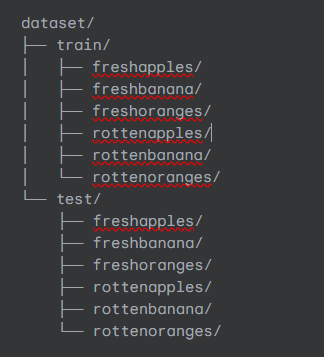


## 2. importacion de librerias 

Se realiza la importación de las diferentes librerías que se utilizarán durante el proceso.

In [15]:
# priemro importamos las librerias 
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt



## 3. Normalizar datos 

Teniendo en cuenta que se va a utilizar el modelo MobileNetV2, y este espera que las imágenes estén en un formato específico, se deben hacer ciertos ajustes:

-  3.1 Redimensionamiento:
    - Recorreremos las imágenes originales.
    - Redimensionaremos cada imagen a 224x224 píxeles.
    - Se guardarán en una nueva carpeta, **dataset_224**, con las mismas subcarpetas pero con los tamaños modificados.

-  3.2 Normalización:
    - Conteo de datos. 
    - Si los datos están desbalanceados para el entrenamiento, se procederá a hacer un submuestreo o sobremuestreo.

### 3.1 Redimensionamiento:
A continuación, se reducirá el tamaño de las imágenes. Actualmente, las imágenes están en formato PNG (470x386). Se redimensionarán todas a 224x224 píxeles como lo requiere MobileNetV2 y se guardarán en la nueva carpeta.

In [16]:
# Rutadel dataset 
ruta_dataset_original = "dataset/"  

# Ruta donde se guardará el nuevo dataset redimensionado
ruta_dataset_redimensionado = "dataset_224/"

# Tamaño que necesita MobileNetV2
tamaño_imagen = (224, 224)

# Recorremos train y test
for conjunto in ["train", "test"]:
    ruta_origen = os.path.join(ruta_dataset_original, conjunto)
    ruta_destino = os.path.join(ruta_dataset_redimensionado, conjunto)

    # Crear carpeta destino si no existe
    if not os.path.exists(ruta_destino):
        os.makedirs(ruta_destino)

    # Recorremos cada clase (carpeta) dentro de train/test
    for clase in os.listdir(ruta_origen):
        ruta_clase_origen = os.path.join(ruta_origen, clase)
        ruta_clase_destino = os.path.join(ruta_destino, clase)

        # Crear carpeta de clase en destino si no existe
        if not os.path.exists(ruta_clase_destino):
            os.makedirs(ruta_clase_destino)

        # Recorremos cada imagen de la clase
        for archivo in tqdm(os.listdir(ruta_clase_origen), desc=f"{conjunto}/{clase}"):
            ruta_img = os.path.join(ruta_clase_origen, archivo)

            # Leer imagen con OpenCV
            img = cv2.imread(ruta_img)
            if img is None:
                print(f"No se pudo leer {ruta_img}")
                continue

            # Redimensionar imagen a 224x224
            img_redim = cv2.resize(img, tamaño_imagen)

            # Guardar directamente la imagen redimensionada
            ruta_salida = os.path.join(ruta_clase_destino, archivo)
            cv2.imwrite(ruta_salida, img_redim)

test/rottenoranges: 100%|██████████| 403/403 [00:01<00:00, 236.92it/s]


### 3.2 Normalizacion 
 - conteo de datos
 - analicis de datos 
 
    


**conteo de datos**

a continucacion se verificaran  cuantos datos hay en la nueva carpeta, y luego se desidira que es lo mejor 

In [17]:

ruta_train = "dataset_224/train/"  

conteo_clases = {}
for clase in os.listdir(ruta_train):
    ruta_clase = os.path.join(ruta_train, clase)
    if os.path.isdir(ruta_clase):
        total = len(os.listdir(ruta_clase))
        conteo_clases[clase] = total

print("Conteo de imágenes por clase:")
for clase, cantidad in conteo_clases.items():
    print(f"{clase}: {cantidad}")


Conteo de imágenes por clase:
freshapples: 1693
freshbanana: 1581
freshoranges: 1466
rottenapples: 2342
rottenbanana: 2224
rottenoranges: 1595


 **analicis de datos**

Como se puede observar, el dataset presenta un desbalanceo en la cantidad de imágenes por clase. Por lo tanto, se decidió equilibrar a un promedio de 1800 imágenes por clase, reduciendo ligeramente las clases con exceso de datos y aumentando aquellas con pocos ejemplos.

teniendo encuenta que: 
   - Aprovecha datos reales y aumentados.
   - Minimiza pérdida o exceso.
   - potencia de equipos baja.


   Aumentar datos con ImageDataGenerator


In [18]:
ruta_train = "dataset_224/train/"# Ruta de entrenamiento
tamaño_objetivo = 1800  # imágenes por clase
tamaño_img = (224, 224) # Tamaño de las imágenes (consistente con MobileNetV2)

# Configuración del generador de aumentación de datos (Data Augmentation)
aumentador = ImageDataGenerator(
    rotation_range=25,       # Rango de rotación aleatoria (grados)
    width_shift_range=0.1,   # Desplazamiento horizontal aleatorio (10% del ancho)
    height_shift_range=0.1,  # Desplazamiento vertical aleatorio (10% del alto)
    shear_range=0.1,         # Inclinación aleatoria (deformación)
    zoom_range=0.2,          # Zoom aleatorio (20% de acercamiento/alejamiento)
    horizontal_flip=True,    # Volteo horizontal aleatorio
    fill_mode='nearest'      # Rellena pixeles vacíos tras transformaciones
)

# Recorre cada clase 
for clase in os.listdir(ruta_train):
    ruta_clase = os.path.join(ruta_train, clase)
    if not os.path.isdir(ruta_clase):
        continue  # Ignora archivos que no sean carpetas

    imagenes = os.listdir(ruta_clase)
    total_actual = len(imagenes)

    print(f"\nClase: {clase} - Imágenes actuales: {total_actual}")

    # 🔻 SUBMUESTREO si hay más de 1800
    if total_actual > tamaño_objetivo:
        exceso = total_actual - tamaño_objetivo
        print(f" - Submuestreando: eliminando {exceso} imágenes...")
        eliminar = random.sample(imagenes, exceso) # Selección aleatoria
        for archivo in eliminar:
            ruta_eliminar = os.path.join(ruta_clase, archivo)
            os.remove(ruta_eliminar)

    # 🔺 AUMENTO si hay menos de 1800
    elif total_actual < tamaño_objetivo:
        deficit = tamaño_objetivo - total_actual
        print(f" - Aumentando: generando {deficit} imágenes...")
        i = 0
        idx = 0
        while i < deficit:
             # Selecciona una imagen existente 
            img_nombre = imagenes[idx % total_actual]
            ruta_img = os.path.join(ruta_clase, img_nombre)
            img = cv2.imread(ruta_img)

            if img is None: # Si la imagen está corrupta, salta
                idx += 1
                continue

            img = cv2.resize(img, tamaño_img)  # Asegura tamaño 224x224
            img = img.reshape((1,) + img.shape)  # Reformatea para Keras

            for lote in aumentador.flow(img, batch_size=1):
                nueva_img = lote[0].astype(np.uint8) # Convierte a formato válido
                nombre_archivo = f"{clase}_aug_{i}.png"
                ruta_salida = os.path.join(ruta_clase, nombre_archivo)
                cv2.imwrite(ruta_salida, nueva_img)
                i += 1
                break  # solo una imagen por vez
            idx += 1

print("\n✅ Todas las clases ahora tienen 1800 imágenes exactamente.")


Clase: freshapples - Imágenes actuales: 1693
 - Aumentando: generando 107 imágenes...

Clase: freshbanana - Imágenes actuales: 1581
 - Aumentando: generando 219 imágenes...

Clase: freshoranges - Imágenes actuales: 1466
 - Aumentando: generando 334 imágenes...

Clase: rottenapples - Imágenes actuales: 2342
 - Submuestreando: eliminando 542 imágenes...

Clase: rottenbanana - Imágenes actuales: 2224
 - Submuestreando: eliminando 424 imágenes...

Clase: rottenoranges - Imágenes actuales: 1595
 - Aumentando: generando 205 imágenes...

✅ Todas las clases ahora tienen 1800 imágenes exactamente.


In [19]:
ruta_train = "dataset_224/train/"  

conteo_clases = {}
for clase in os.listdir(ruta_train):
    ruta_clase = os.path.join(ruta_train, clase)
    if os.path.isdir(ruta_clase):
        total = len(os.listdir(ruta_clase))
        conteo_clases[clase] = total

print("Conteo de imágenes por clase:")
for clase, cantidad in conteo_clases.items():
    print(f"{clase}: {cantidad}")

Conteo de imágenes por clase:
freshapples: 1800
freshbanana: 1800
freshoranges: 1800
rottenapples: 1800
rottenbanana: 1800
rottenoranges: 1800


## 4.Cargar las imágenes de entrenamiento y test

Después de preparar las imágenes, es necesario que Python las lea y organice para el entrenamiento del modelo.

- 4.1 Cargar el dataset para entrenamiento.
- 4.2 # preguntar 
AUTOTUNE = tf.data.AUTOTUNE

- 4.3 Visualizar imágenes y etiquetas del dataset cargado



### 4.1 Cargar el dataset para entrenamiento. 

lo primero que se hara es  definir parámetros y rutas

- Le decimos a TensorFlow dónde están tus imágenes (dataset_224/train y dataset_224/test).
- Le indicamos el tamaño final de las imágenes.
- cuántas imágenes cargar por paso (32 es lo común).

- Asocia el nombre de la carpeta como etiqueta (por ejemplo: freshapples)
|Convierte las etiquetas en vectores categóricos ([0,0,1,0,...])

In [20]:

ruta_base = "dataset_224/" # Ya contiene imágenes balanceadas y de 224x224
batch_size = 32  # Tamaño del lote para entrenamiento


# Dataset de entrenamiento (ya balanceado a 1800 imágenes/clase)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(ruta_base, "train"),
    batch_size=batch_size, # CARGA LAS IMAGENES EN MEMORIA 
     image_size=(224, 224),  # ✅ Muy importante: asegura la forma correcta del tensor
    label_mode="categorical" 
)

# Dataset de prueba (sin aumentación, solo evaluación)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(ruta_base, "test"),
    batch_size=batch_size,
    image_size=(224, 224),  # ✅ También para el conjunto de prueba
    label_mode="categorical"# porque MobileNetV2 espera etiquetas como vectores
)


Found 10800 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.


### 4.2 

- **shuffle(1000)** qué hace: Mezcla aleatoriamente los datos con un buffer de 1,000 muestras.

    Beneficio:

Evita que el modelo aprenda patrones artificiales por el orden de los datos.
Importante para evitar sobreajuste (especialmente si los datos están ordenados por clase).

- **prefetch** Qué hace: Prepara los siguientes lotes de datos mientras el modelo está entrenando.

    Beneficio:

    Elimina tiempos muertos (cuando la GPU está inactiva esperando datos).
    Acelera el entrenamiento hasta un 30%.


### preguntar ( )


In [31]:
# Optimización definitiva para tu dataset de frutas
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

### 4.3 Visualizar imágenes y etiquetas del dataset cargado
Este código mostrará algunas imágenes del dataset con su clase correspondiente, para confirmamr visualmente que todo está bien.

Clases detectadas: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


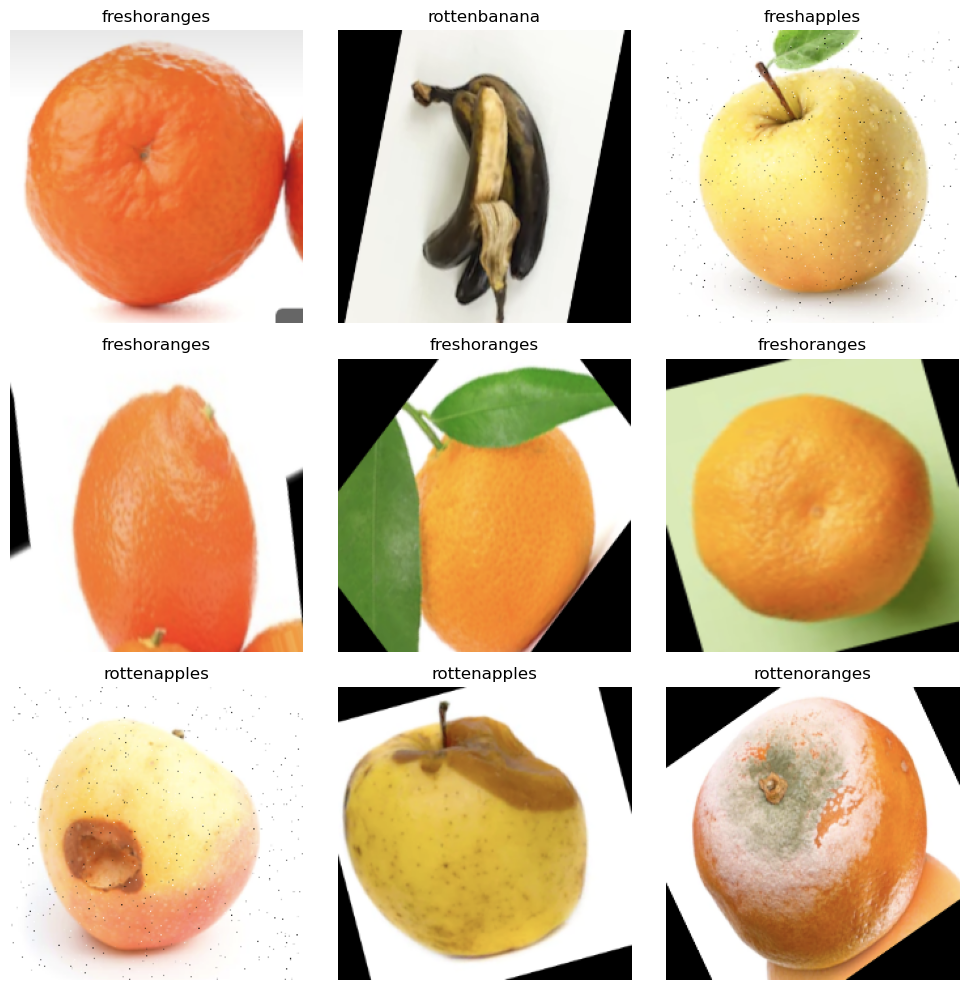

In [21]:


# Obtener las clases detectadas automáticamente
class_names = train_ds.class_names
print("Clases detectadas:", class_names)

# Mostrar 9 imágenes con sus etiquetas
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Tomar un solo batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i].numpy())  # Convertir one-hot a número
        plt.title(class_names[class_index])
        plt.axis("off")

plt.tight_layout()
plt.show()


## 5. Qué es MobileNetV2 con Fine Tuning?

MobileNetV2 es un modelo de redes neuronales ya entrenado en millones de imágenes (Imagenet). Lo usaremos como "base" y le añadiremos nuestras propias capas para que aprenda a clasificar frutas frescas y podridas.

Fine tuning significa:

Congelar las primeras capas (ya entrenadas) y ajustar solo las últimas para tu problema.

### 🤖 ¿Qué es el fine-tuning?
Cuando usas un modelo como MobileNetV2 con weights='imagenet', estás usando una red previamente entrenada con millones de imágenes. Las primeras capas aprenden características muy generales (como bordes, texturas), y las últimas capas aprenden características más específicas de las clases con las que fue entrenado (como patas, ojos, ruedas...).

obileNetV2 fueron entrenados originalmente con imágenes normalizadas entre 0 y 1 o con

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar MobileNetV2 sin la capa de clasificación (include_top=False)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelamos todas las capas por ahora
base_model.trainable = True

# Añadimos nuevas capas encima
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dropout(0.3)(x)  # Dropout para evitar sobreajuste
x = Dense(128, activation='relu')(x)  # Capa intermedia
output = Dense(6, activation='softmax')(x)  # Capa final para 6 clases

# Modelo completo
modelo = Model(inputs=base_model.input, outputs=output)

# Compilamos
modelo.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelo.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

## 6. Entrenar y evaluar tu modelo con precisión.

- 6.1 entrenar los datos y prebiamente configurados y arreglados 
- 6.2 Evaluar  el modelo

### 6.1 procedemos a entrenar el modelo 

En este punto se inicia el proceso de entrenamiento supervisado del modelo con los datos preparados previamente. Se utiliza el método fit() para entrenar la red neuronal sobre el conjunto de entrenamiento (train_ds) y evaluar su desempeño en cada época con el conjunto de validación (test_ds).



In [ ]:


history = modelo.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10  # Puedes cambiar 5 por más o menos según tu tiempo
)


Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.8654 - loss: 0.4077 - val_accuracy: 0.6972 - val_loss: 1.0593
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.9924 - loss: 0.0227 - val_accuracy: 0.8580 - val_loss: 0.5702
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9959 - loss: 0.0135 - val_accuracy: 0.9655 - val_loss: 0.1144
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.9950 - loss: 0.0134 - val_accuracy: 0.9518 - val_loss: 0.1733
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.9949 - loss: 0.0145 - val_accuracy: 0.9922 - val_loss: 0.0247
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.9968 - loss: 0.0132 - val_accuracy: 0.9970 - val_loss: 0.0093
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 0.9970 - val_loss: 0.0094
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.9970 - loss: 0.0096 - val_accu

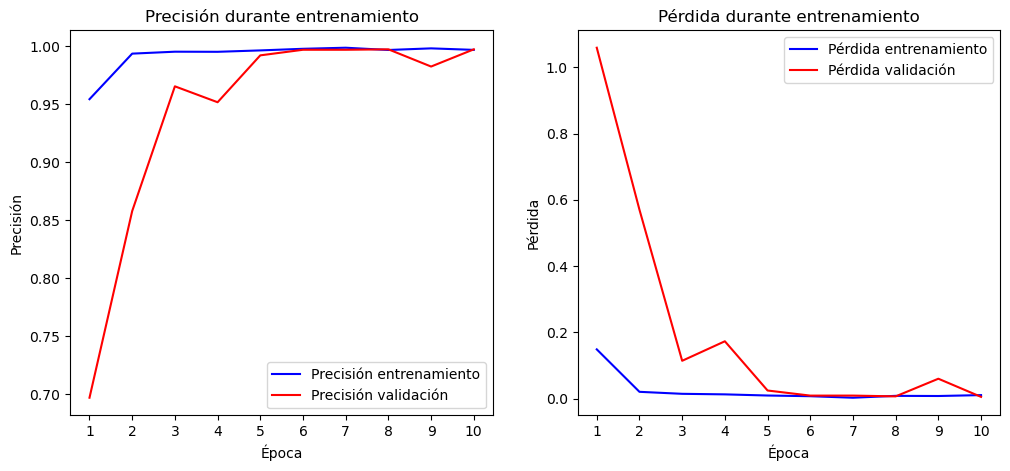

In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extraemos datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Gráfica de precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Precisión entrenamiento')
    plt.plot(epochs, val_acc, 'r-', label='Precisión validación')
    plt.title('Precisión durante entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.xticks(epochs)
    plt.legend()

    # Gráfica de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r-', label='Pérdida validación')
    plt.title('Pérdida durante entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.xticks(epochs)
    plt.legend()

    plt.show()

# Llamar a la función con el objeto history de fit
plot_history(history)


### 6.2 Evaluar  el modelo

En esta sección se evalúa el rendimiento final del modelo entrenado utilizando el conjunto de prueba (test_ds). Para ello, se calculan las predicciones del modelo y se comparan con las etiquetas reales de las imágenes.

Se hace uso de herramientas de la biblioteca sklearn para generar una matriz de confusión, la cual permite visualizar en detalle qué tan bien el modelo clasifica cada categoría. En dicha matriz:

- Cada fila representa la clase real.

- Cada columna representa la clase predicha por el modelo.

- Los valores diagonales indican aciertos.

- Los valores fuera de la diagonal representan errores de clasificación.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

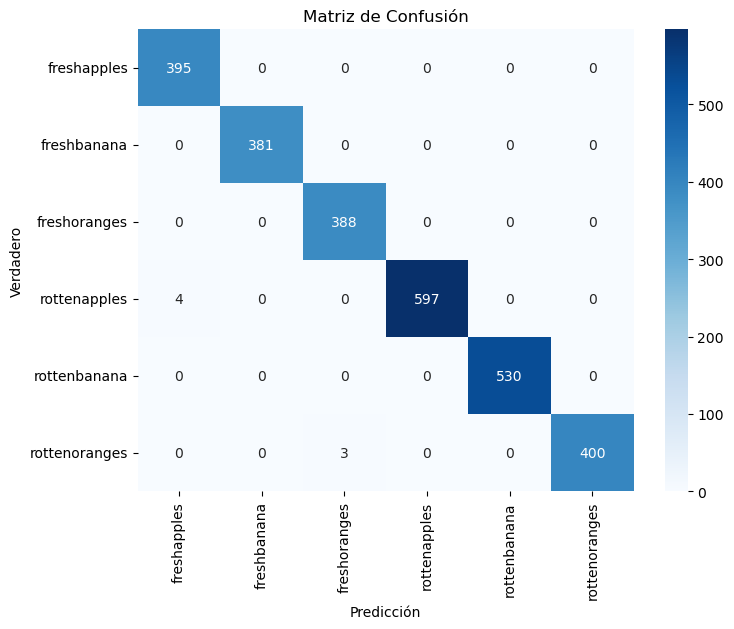


Reporte de clasificación:

               precision    recall  f1-score   support

  freshapples       0.99      1.00      0.99       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       0.99      1.00      1.00       388
 rottenapples       1.00      0.99      1.00       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       1.00      0.99      1.00       403

     accuracy                           1.00      2698
    macro avg       1.00      1.00      1.00      2698
 weighted avg       1.00      1.00      1.00      2698



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones del modelo
y_true = []
y_pred = []

for images, labels in test_ds:  # test_ds ya está definido
    preds = modelo.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

# Reporte detallado
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
